In [ ]:
try: 
    from imutils import paths 
except:
    !pip install imutils
    from imutils import paths 
    
try: 
    import tensorflow_similarity as tfsim
except: 
    %pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

In [2]:
import os 
from tqdm import tqdm 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import shutil
import cv2 
from tensorflow import keras 
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Input, Lambda, Conv2D, MaxPooling2D, \
                                    GlobalAveragePooling2D, ReLU, ELU,BatchNormalization
from tensorflow.keras.models import Model 

In [3]:
DATA_DIR_PATH = "/kaggle/input/stl10"
TRAIN_DATA_DIR_PATH = os.path.join(DATA_DIR_PATH, "train_images")
TEST_DATA_DIR_PATH = os.path.join(DATA_DIR_PATH, "test_images")
UNLABELED_DATA_DIR_PATH = os.path.join(DATA_DIR_PATH, "unlabeled_images")
STL_IMG_SHAPE = 96

In [ ]:
unlabeled_image_files_path = list(paths.list_files(UNLABELED_DATA_DIR_PATH))

In [ ]:
# 100 thosand unlabelled images.
len(unlabeled_image_files_path) == 1_00_000

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [6]:
random_indxs = np.random.choice(np.arange(10000), 5000, replace=False)
valid_X, valid_y = x_test[random_indxs], y_test[random_indxs]

In [19]:
# Image preprocessing utils
def preprocess_image(image, label): 
    """
        this function, will read the image from the directory, and resize it to the 224 image shape, which is predefined 
        image shape of Resnet pretrained model.
        Params:
            image_path(type: str): image filepath in the directory.
        Return(type: tf.Image)
            returns the preprocessed image.
    """
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 10)
    label = tf.reshape(label, (10, ))
    image = tf.image.resize(image, (96, 96))
    
    return (image, label)


def create_tensorflow_dataset(data, batch_size):
    """
        this function, will create the tensorflow dataset from the images.
        Params:
            data(type: List): list of data, in our case list contains the file path.
            batch_size(type: Int): batch size for the generator.
        Return(type: tf.data.Dataset)
            returns tensorflow dataset object.
    """
    tensorflow_data = tf.data.Dataset.from_tensor_slices(data)
    tensorflow_data = (
    tensorflow_data
        .map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .shuffle(1024)
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return tensorflow_data   

In [44]:
import matplotlib.pyplot as plt 

def plot_acc(history): 
    with plt.xkcd():
        plt.plot(history.history["acc"], label="train_acc")
        plt.plot(history.history["val_acc"], label="val_acc")
        plt.title("Training and val Accuracy")
        plt.xlabel("Epoch #")
        plt.ylabel("Accuracy")
        plt.legend(loc="lower left")
        
        plt.show()
        
def plot_loss(history):  
    with plt.xkcd():
        plt.plot(history.history["loss"], label="train_loss")
        plt.plot(history.history["val_loss"], label="val_loss")

        plt.title("Training Loss and val loss")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend(loc="lower left")
        
        plt.show()

In [68]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

class Metrics: 
    def __init__(self, y_preds, y_trues, class_names, avg, heatmap=True):
        """
            this class has a multiple methods that has multiple evulation metrics for the evaulating the prediction data.
            Attrs:
                y_preds(type: np.array): prediction from the model.
                y_trues(type; np.array): Actual value(true value) of the dataset.
                class_names(type: List): list of classes.
                avg(type: str): Type of method for averaging the multiclass values.
        """
        self.y_preds = y_preds 
        self.y_trues = y_trues 
        self.class_names = class_names
        self.avg = avg 
        self.heatmap = heatmap

    @property
    def get_classification_report(self):
        """
            returns the classiction report.
        """
        report = classification_report(self.y_trues, self.y_preds)
        return report

    @property
    def f1score(self): 
        """
            returns the f1 score.
        """
        score = f1_score(self.y_trues. self.y_preds, average=self.avg)
        return score 
        
    @property
    def accuracy(self):
        """
            returns the accuracy
        """
        acc = accuracy_score(self.y_trues, self.y_preds)
        return acc 

    @property
    def heatmap_cmat(self): 
        """
            returns the heatmap for the confusion matrix.
        """
        mat = confusion_matrix(self.y_trues, self.y_preds)
        sns.heatmap(
                    mat.T, 
                    square=True, 
                    annot=True, 
                    fmt='d', 
                    cbar=False,
                    xticklabels=self.class_names,
                    yticklabels=self.class_names
                )
        plt.xlabel('true label')
        plt.ylabel('predicted label');

In [20]:
train_ds = create_tensorflow_dataset((x_train, y_train), 32)
val_ds = create_tensorflow_dataset((valid_X, valid_y), 32)

In [33]:
def get_encoder(input_dims, hidden_dims, out_dims, encoder_trainable=True):
    base_model = tf.keras.applications.ResNet50(include_top=False,
        weights=None, input_shape=input_dims)
    base_model.trainable = encoder_trainable

    inputs = tf.keras.layers.Input(input_dims, name="input layer")
    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D(name="gap")(x)
    x = Dense(hidden_dims, use_bias=False, name="d1")(x)
    x = BatchNormalization(name="bn1")(x)
    x = ReLU(name="r1")(x)
    x = Dense(hidden_dims, use_bias=False, name="d2")(x)
    x = BatchNormalization(name="bn2")(x)
    x = ReLU(name="r2")(x)
    z = Dense(out_dims, name="output_layer")(x)

    f = tf.keras.Model(inputs, z)

    
    return f

In [48]:
trained_encoder = get_encoder((96, 96, 3), 2048, 2048)
trained_encoder.load_weights("encoder_simsiam_25_epochs.h5")
trained_encoder.layers[1].trainable = False
trained_encoder.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                                 
 d1 (Dense)                  (None, 2048)              4194304   
                                                                 
 bn1 (BatchNormalization)    (None, 2048)              8192      
                                                                 
 r1 (ReLU)                   (None, 2048)              0         
                                                          

In [49]:
clf_model = keras.models.Sequential([
    Input(shape=(96, 96, 3)),
    trained_encoder,
    Dense(10, activation="softmax")
])

clf_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_10 (Functional)       (None, 2048)              36189056  
                                                                 
 dense_3 (Dense)             (None, 10)                20490     
                                                                 
Total params: 36,209,546
Trainable params: 36,148,234
Non-trainable params: 61,312
_________________________________________________________________


In [50]:
clf_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics='acc')
history = clf_model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
1562/1562 [==============================] - 167s 65ms/step - loss: 2.3107 - acc: 0.3156 - val_loss: 1.5323 - val_acc: 0.4399
Epoch 2/50
1562/1562 [==============================] - 102s 65ms/step - loss: 1.6358 - acc: 0.4013 - val_loss: 1.7097 - val_acc: 0.3690
Epoch 3/50
1562/1562 [==============================] - 102s 65ms/step - loss: 1.6589 - acc: 0.3952 - val_loss: 1.6771 - val_acc: 0.3950
Epoch 4/50
1562/1562 [==============================] - 100s 64ms/step - loss: 1.6974 - acc: 0.3787 - val_loss: 1.6338 - val_acc: 0.4159
Epoch 5/50
1562/1562 [==============================] - 100s 64ms/step - loss: 1.5207 - acc: 0.4443 - val_loss: 1.4108 - val_acc: 0.4798
Epoch 6/50
1562/1562 [==============================] - 100s 64ms/step - loss: 1.3924 - acc: 0.4935 - val_loss: 1.2718 - val_acc: 0.5405
Epoch 7/50
1562/1562 [==============================] - 100s 64ms/step - loss: 1.3484 - acc: 0.5180 - val_loss: 1.2724 - val_acc: 0.5369
Epoch 8/50
1562/1562 [===================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 103s 66ms/step - loss: 0.3580 - acc: 0.8722 - val_loss: 1.1484 - val_acc: 0.6879
Epoch 43/50
1562/1562 [==============================] - 104s 66ms/step - loss: 0.1781 - acc: 0.9360 - val_loss: 1.4664 - val_acc: 0.7013
Epoch 44/50
1562/1562 [==============================] - 103s 66ms/step - loss: 0.2285 - acc: 0.9208 - val_loss: 1.5533 - val_acc: 0.6298
Epoch 45/50
1562/1562 [==============================] - 103s 66ms/step - loss: 0.2413 - acc: 0.9149 - val_loss: 1.5186 - val_acc: 0.6957
Epoch 46/50
1562/1562 [==============================] - 103s 66ms/step - loss: 0.1839 - acc: 0.9337 - val_loss: 1.4588 - val_acc: 0.6941
Epoch 47/50
1562/1562 [==============================] - 101s 65ms/step - loss: 0.2445 - acc: 0.9134 - val_loss: 1.3981 - val_acc: 0.6903
Epoch 48/50
1562/1562 [==============================] - 101s 65ms/step - loss: 0.2772 - acc: 0.9024 - val_loss: 1.3156 - val_acc: 0.6815
Epoch 49/50
1562/1562 [=======================

In [61]:
clf_model.save("cifar10_classifier.h5")

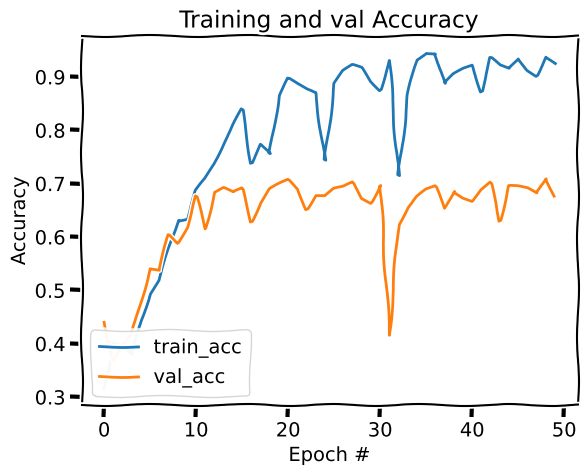

In [51]:
plot_acc(history)


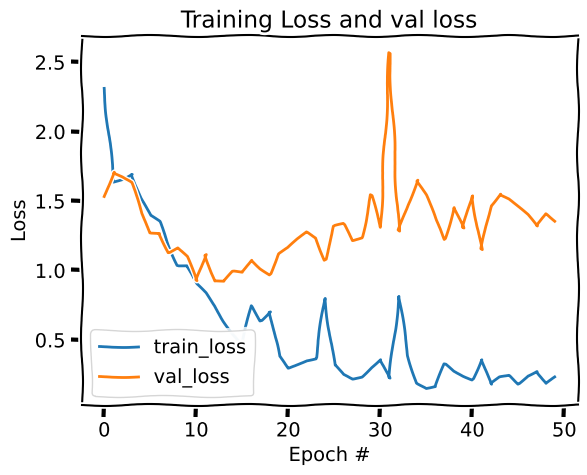

In [52]:
plot_loss(history)

In [58]:
test_indxs = [indx for indx in (np.arange(10000)) if indx not in random_indxs]

In [60]:
test_X, test_y = x_test[test_indxs], y_test[test_indxs]

In [72]:
test_y.shape

(5000, 1)

In [73]:
test_ds = create_tensorflow_dataset((test_X, test_y), 50)

In [78]:
pred_y = clf_model.predict(test_ds)
pred_y = np.argmax(pred_y, axis=1)

100/100 [==============================] - 3s 27ms/step


In [81]:
pred_y

array([3, 1, 4, ..., 4, 0, 7])

In [79]:
cust_metric = Metrics(pred_y, test_y, None, "weighted", True)

In [82]:
clf_model.evaluate(test_ds)

100/100 [==============================] - 4s 30ms/step - loss: 1.3522 - acc: 0.6868


[1.3522486686706543, 0.6868000030517578]